# Single-label Regression using  Multiple Layer Perceptron

## Section 1: Setup 

In [1]:
# import required packages
import PredictMD
import CSV
import DataFrames
import GZip
import Knet
import StatsBase

# set the seed of the global random number generator
# this makes the results reproducible
srand(999)

MersenneTwister(UInt32[0x000003e7], Base.dSFMT.DSFMT_state(Int32[-412893719, 1072748155, -748568654, 1073610384, -1271302057, 1073556021, -429186579, 1073162675, 932796209, 1073458022  …  1115928124, 1073598513, 1280798571, 1072732908, -581554620, 1977796709, 1774936613, -1100988421, 382, 0]), [1.95356, 1.42529, 1.71404, 1.90562, 1.91634, 1.30429, 1.39097, 1.53682, 1.91387, 1.99986  …  1.7474, 1.37092, 1.02709, 1.45976, 1.54413, 1.04316, 1.03421, 1.03289, 1.82133, 1.35197], 382)

## Running for the first time

If you are running this file for the first time and/or if you do not have
any trained models saved to disk, uncomment the lines below to train a model and save it to disk

In [2]:
load_pretrained = false
save_trained = true

true

## Using a pre-trained model

If you already have trained models saved, and you would like to load those. Uncomment the lines below

In [3]:
# load_trained = true
# save_trained = false

## Set your paths

In [4]:
knetmlpreg_filename = "./knetmlpreg.jld2"

"./knetmlpreg.jld2"

## Section 2: Prepare data 

In [5]:
# Import Boston housing data
df = CSV.read(
    GZip.gzopen(joinpath(Pkg.dir("RDatasets"),"data","MASS","Boston.csv.gz")),
    DataFrames.DataFrame,
    )

#take a quick look at file header and few rows
DataFrames.head(df)

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat,MedV
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [6]:
# Remove rows with missing data
DataFrames.dropmissing!(df)

# Shuffle rows
PredictMD.shuffle_rows!(df)

# Define labels
categoricalfeaturenames = Symbol[]

continuousfeaturenames = Symbol[
    :Crim,
    :Zn,
    :Indus,
    :Chas,
    :NOx,
    :Rm,
    :Age,
    :Dis,
    :Rad,
    :Tax,
    :PTRatio,
    :Black,
    :LStat,
    ]
featurenames = vcat(categoricalfeaturenames, continuousfeaturenames)

13-element Array{Symbol,1}:
 :Crim   
 :Zn     
 :Indus  
 :Chas   
 :NOx    
 :Rm     
 :Age    
 :Dis    
 :Rad    
 :Tax    
 :PTRatio
 :Black  
 :LStat  

In [7]:
if load_pretrained == "true"
else
    featurecontrasts = PredictMD.featurecontrasts(df, featurenames)
end

PredictMD.ImmutableDataFrameFeatureContrasts(Symbol[:Crim, :Zn, :Indus, :Chas, :NOx, :Rm, :Age, :Dis, :Rad, :Tax, :PTRatio, :Black, :LStat], 13, Dict{Symbol,StatsModels.ContrastsMatrix}(), 13)

In [8]:
# Define labels
labelname = :MedV

# Put features and labels in separate dataframes
featuresdf = df[featurenames]
labelsdf = df[[labelname]]

# Display for exploration
display(DataFrames.head(featuresdf))
display(DataFrames.head(labelsdf))

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat
1,88.9762,0.0,18.1,0,0.671,6.968,91.9,1.4165,24,666,20.2,396.9,17.21
2,0.06047,0.0,2.46,0,0.488,6.153,68.8,3.2797,3,193,17.8,387.11,13.15
3,0.1712,0.0,8.56,0,0.52,5.836,91.9,2.211,5,384,20.9,395.67,18.66
4,0.54452,0.0,21.89,0,0.624,6.151,97.9,1.6687,4,437,21.2,396.9,18.46
5,0.03466,35.0,6.06,0,0.4379,6.031,23.3,6.6407,1,304,16.9,362.25,7.83
6,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.118,4,224,14.7,390.55,2.88


,MedV
1,10.4
2,29.6
3,19.5
4,17.8
5,19.4
6,50.0


In [9]:
# View summary statistics for label variable (mean, quartiles, etc.)
DataFrames.describe(labelsdf[labelname])

Summary Stats:
Mean:           22.532806
Minimum:        5.000000
1st Quartile:   17.025000
Median:         21.200000
3rd Quartile:   25.000000
Maximum:        50.000000
Length:         506
Type:           Union{Float64, Missings.Missing}
Number Missing: 0
% Missing:      0.000000


In [10]:
# Split data into training set (70%) and testing set (30%)
trainingfeaturesdf,testingfeaturesdf,traininglabelsdf,testinglabelsdf =
    PredictMD.train_test_split(featuresdf,labelsdf;training = 0.7,testing = 0.3,);

## Section 3: Set up and train models 

### Multilayer perceptron (i.e. fully connected feedforward neural network)

In [11]:
# Define predict function
function knetmlp_predict(
        w, # don't put a type annotation on this
        x0::AbstractArray;
        training::Bool = false,
        )
    # x0 = input layer
    # x1 = hidden layer
    x1 = Knet.relu.( w[1]*x0 .+ w[2] ) # w[1] = weights, w[2] = biases
    # x2 = output layer
    x2 = w[3]*x1 .+ w[4] # w[3] = weights, w[4] = biases
    return x2
end

knetmlp_predict (generic function with 1 method)

In [12]:
if load_pretrained
    # No need to initialize weights since we are going to load them from file
    knetmlp_modelweights = Any[]
else
    # Randomly initialize model weights
    knetmlp_modelweights = Any[
        # input layer has dimension featurecontrasts.numarrayfeatures
        #
        # hidden layer (10 neurons):
        Cfloat.(
            0.1f0*randn(Cfloat,10,featurecontrasts.numarrayfeatures) # weights
            ),
        Cfloat.(
            zeros(Cfloat,10,1) # biases
            ),
        #
        # output layer (regression nets have exactly 1 neuron in output layer):
        Cfloat.(
            0.1f0*randn(Cfloat,1,10) # weights
            ),
        Cfloat.(
            zeros(Cfloat,1,1) # biases
            ),
        ]
end

4-element Array{Any,1}:
 Float32[-0.0897565 0.0974769 … -0.260205 0.0299987; 0.0725558 -0.0355528 … -0.0390284 0.0524487; … ; -0.0717704 -0.10111 … -0.0631411 -0.0306858; 0.00933819 -0.046184 … 0.326549 -0.0479391]
 Float32[0.0; 0.0; … ; 0.0; 0.0]                                                                                                                                                              
 Float32[0.03517 0.0896541 … -0.18434 0.0292523]                                                                                                                                              
 Float32[0.0]                                                                                                                                                                                 

In [13]:
# Define loss function
function knetmlp_loss(
        predict::Function,
        modelweights, # don't put a type annotation on this
        x::AbstractArray,
        ytrue::AbstractArray;
        L1::Real = Cfloat(0),
        L2::Real = Cfloat(0),
        )
    loss = mean(
        abs2,
        ytrue - predict(modelweights, x),
        )
    if L1 != 0
        loss += L1 * sum(sum(abs, w_i) for w_i in modelweights[1:2:end])
    end
    if L2 != 0
        loss += L2 * sum(sum(abs2, w_i) for w_i in modelweights[1:2:end])
    end
    return loss
end

knetmlp_loss (generic function with 1 method)

In [14]:
# Define loss hyperparameters
knetmlp_losshyperparameters = Dict()
knetmlp_losshyperparameters[:L1] = Cfloat(0.0)
knetmlp_losshyperparameters[:L2] = Cfloat(0.0)

# Select optimization algorithm
knetmlp_optimizationalgorithm = :Adam

# Set optimization hyperparameters
knetmlp_optimizerhyperparameters = Dict()

# Set the minibatch size
knetmlp_minibatchsize = 48

# Set the max number of epochs. After training, look at the learning curve. If
# it looks like the model has not yet converged, raise maxepochs. If it looks
# like the loss has hit a plateau and you are worried about overfitting, lower
# maxepochs.
knetmlp_maxepochs = 500

# Set up multilayer perceptron model
knetmlpreg = PredictMD.singlelabeldataframeknetregression(
    featurenames,
    labelname;
    package = :Knetjl,
    name = "Knet MLP",
    predict = knetmlp_predict,
    loss = knetmlp_loss,
    losshyperparameters = knetmlp_losshyperparameters,
    optimizationalgorithm = knetmlp_optimizationalgorithm,
    optimizerhyperparameters = knetmlp_optimizerhyperparameters,
    minibatchsize = knetmlp_minibatchsize,
    modelweights = knetmlp_modelweights,
    maxepochs = knetmlp_maxepochs,
    printlosseverynepochs = 100, # if 0, will not print at all
    )

if load_pretrained == "true"
    PredictMD.load!(knetmlpreg_filename, knetmlpreg)
else
    # set feature contrasts
    PredictMD.setfeaturecontrasts!(knetmlpreg, featurecontrasts)
    # Train multilayer perceptron model on training set
    PredictMD.fit!(knetmlpreg,trainingfeaturesdf,traininglabelsdf,)
end

INFO: Starting to train Knet.jl model. Max epochs: 500.
INFO: Epoch: 0. Loss: 293.5584.
INFO: Epoch: 100. Loss: 37.992123.
INFO: Epoch: 200. Loss: 27.809109.
INFO: Epoch: 300. Loss: 25.35328.
INFO: Epoch: 400. Loss: 23.582445.
INFO: Epoch: 500. Loss: 22.027395.
INFO: Finished training Knet.jl model.


PredictMD.KnetModel("Knet MLP", false, true, knetmlp_predict, knetmlp_loss, Dict{Any,Any}(Pair{Any,Any}(:L2, 0.0),Pair{Any,Any}(:L1, 0.0)), :Adam, Dict{Any,Any}(), 48, 500, 100, Any[Float32[-0.104315 0.0974769 … -0.275 0.0135046; 0.0725558 -0.0355528 … -0.0390284 0.0524487; … ; 0.0200607 0.00669115 … 0.0202091 0.516147; -0.206359 -0.0222494 … 0.412806 -0.906976], Float32[-0.0175526; 0.0; … ; -0.571523; 0.380575], Float32[0.0236321 0.0896541 … -0.522333 0.206521], Float32[0.373899]], Knet.Adam[Knet.Adam(0.001, 0.0, 0.9, 0.999, 1.0e-8, 3500, Float32[5.60519f-45 0.0 … 5.60519f-45 5.60519f-45; 0.0 0.0 … 0.0 0.0; … ; -0.506289 -0.21575 … -26.1193 0.587646; 0.0708102 0.0859936 … 10.7848 0.0623458], Float32[2.12288f-5 0.0 … 2.27653f-5 3.43631f-5; 0.0 0.0 … 0.0 0.0; … ; 16.851 412.409 … 38030.4 109.662; 0.434212 76.4882 … 8933.93 11.7333]), Knet.Adam(0.001, 0.0, 0.9, 0.999, 1.0e-8, 3500, Float32[5.60519f-45; 0.0; … ; 0.00653508; 0.00265247], Float32[8.06275f-8; 0.0; … ; 0.305199; 0.0624154]), 

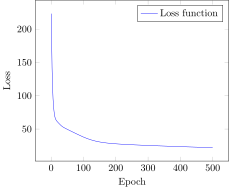

In [15]:
# Plot learning curve: loss vs. epoch
knet_learningcurve_lossvsepoch = PredictMD.plotlearningcurve(
    knetmlpreg,
    :lossvsepoch;
    )

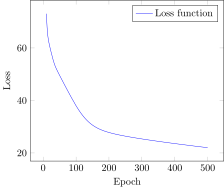

In [16]:
# Plot learning curve: loss vs. epoch, skip the first 10 epochs
knet_learningcurve_lossvsepoch_skip10epochs = PredictMD.plotlearningcurve(
    knetmlpreg,
    :lossvsepoch;
    startat = 10,
    endat = :end,
    )

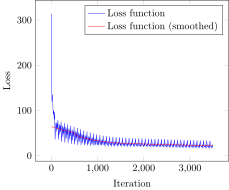

In [17]:
# Plot learning curve: loss vs. iteration
knet_learningcurve_lossvsiteration = PredictMD.plotlearningcurve(
    knetmlpreg,
    :lossvsiteration;
    window = 50,
    sampleevery = 10,
    )

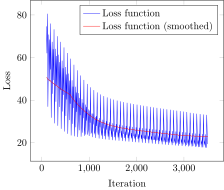

In [18]:
# Plot learning curve: loss vs. iteration, skip the first 100 iterations
knet_learningcurve_lossvsiteration_skip100iterations = PredictMD.plotlearningcurve(
    knetmlpreg,
    :lossvsiteration;
    window = 50,
    sampleevery = 10,
    startat = 100,
    endat = :end,
    )

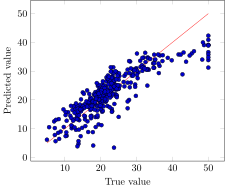

In [19]:
# Plot true values versus predicted values for multilayer perceptron on training set
knetmlpreg_plot_training = PredictMD.plotsinglelabelregressiontrueversuspredicted(
    knetmlpreg,
    trainingfeaturesdf,
    traininglabelsdf,
    labelname,
    )

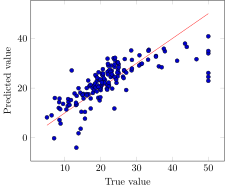

In [20]:
# Plot true values versus predicted values for multilayer perceptron on testing set
knetmlpreg_plot_testing = PredictMD.plotsinglelabelregressiontrueversuspredicted(
    knetmlpreg,
    testingfeaturesdf,
    testinglabelsdf,
    labelname,
    )

In [21]:
# Evaluate performance of multilayer perceptron on training set
PredictMD.singlelabelregressionmetrics(
    knetmlpreg,
    trainingfeaturesdf,
    traininglabelsdf,
    labelname,
    )

,metric,Knet MLP
1,R^2 (coefficient of determination),0.731002


In [22]:
# Evaluate performance of multilayer perceptron on testing set
PredictMD.singlelabelregressionmetrics(
    knetmlpreg,
    testingfeaturesdf,
    testinglabelsdf,
    labelname,
    )

,metric,Knet MLP
1,R^2 (coefficient of determination),0.553721


### Section 4: Save trained models to file (if desired) 

In [23]:
if save_trained
    PredictMD.save(knetmlpreg_filename, knetmlpreg)
end

INFO: Saved model to file ./knetmlpreg.jld2


### Appendix A: Directly access the output of regression models

In [24]:
# We can use the PredictMD.predict() function to get the real-valued predictions
# output by each of regression models.

# Get real-valued predictions from each model for training set
PredictMD.predict(knetmlpreg,trainingfeaturesdf)

,MedV
1,13.6334
2,14.028
3,17.662
4,31.4771
5,17.89
6,25.3657
7,16.8383
8,14.0331
9,12.5159
10,11.4709


In [25]:
# Get real-valued predictions from each model for testing set
PredictMD.predict(knetmlpreg,testingfeaturesdf)

,MedV
1,11.3786
2,40.8475
3,26.0719
4,17.6369
5,24.5806
6,8.18154
7,-0.228879
8,19.2027
9,32.9259
10,20.0316
